#### Домашнее задание "Модели авторегрессии условной гетероскедантичности"

Выберите ряд из первого задания и постройте его модель GARCH.  
Отчет нужно будет оформить в jupyter-ноутбук.

Для модели ARIMA приводить ВР к стационарному виду нет необходимости.  
В то время, как для модели GARCH - это необходимое условие.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import tqdm

from scipy.stats import boxcox
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
monthly_boston_armed_robberies_j = pd.read_csv(r'C:\Users\Urmas\Desktop\Digital\НЕТОЛОГИЯ. ПРОФЕССИЯ DATA SCIENTIST\Временные ряды\Знакомство с временными рядами\Series\monthly-boston-armed-robberies-j.csv')

In [3]:
y = pd.Series(monthly_boston_armed_robberies_j['Count'])

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


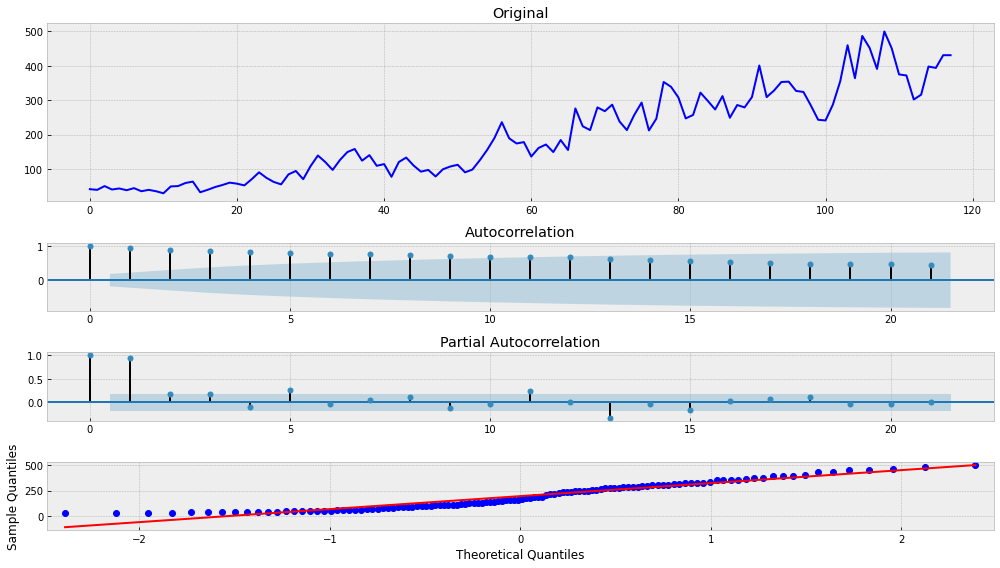

In [6]:
tsplot(y)

In [7]:
# ищем сезонность
# общая функция
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 6))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')    

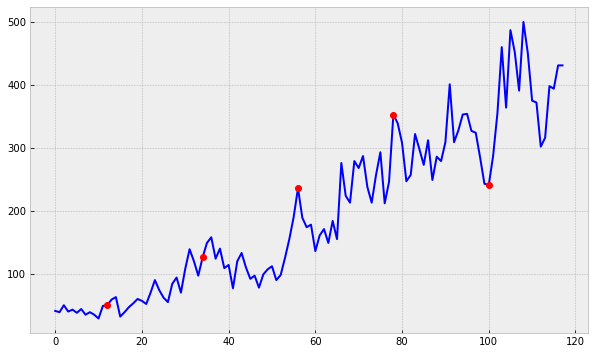

In [8]:
plot_ts_and_points(y, 12, 22)
plt.show()
    

Подобрать сезонность сложно, похоже на шум

ВР y - явно нестационарный ряд с разной дисперсией, трендом и не нормального распределения

Применим модель GARCH к нашему ВР y.  
Сперва с помощью ARIMA подберем параметы, затем используем arch-model

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


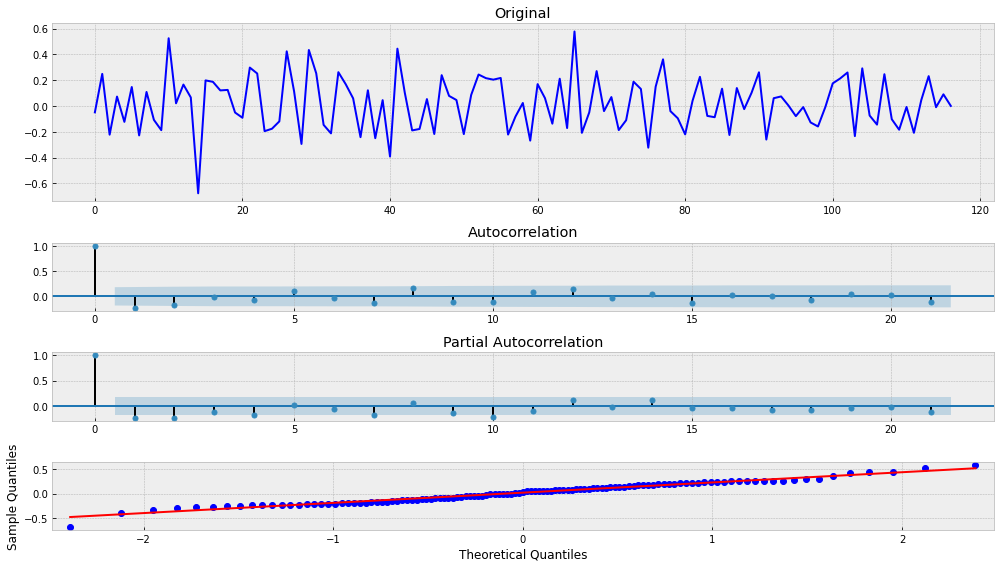

In [9]:
# строим ряд series - копия y с преобразованиями для подачи в GARCH

series = boxcox(y, 0)                   # выравниваем дисперсию
series = np.diff(series, 1)             # убираем тренд
#series = series[12:] - series[:-12]     # убираем сезонность  (у нас нет явной сезонности)
series = pd.Series(series)
tsplot(series)

ВР series привели к стационарному виду

Применяем для поиска параметров p, d, q модель ARIMA

In [10]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [11]:
aic, order, best_mdl = _get_best_model(series)

aic: -44.47600 | order: (2, 0, 4)


Results of Dickey-Fuller Test:
Test Statistic                -1.122894e+01
p-value                        1.929043e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.160000e+02
Critical Value (1%)           -3.488022e+00
Critical Value (5%)           -2.886797e+00
Critical Value (10%)          -2.580241e+00
dtype: float64


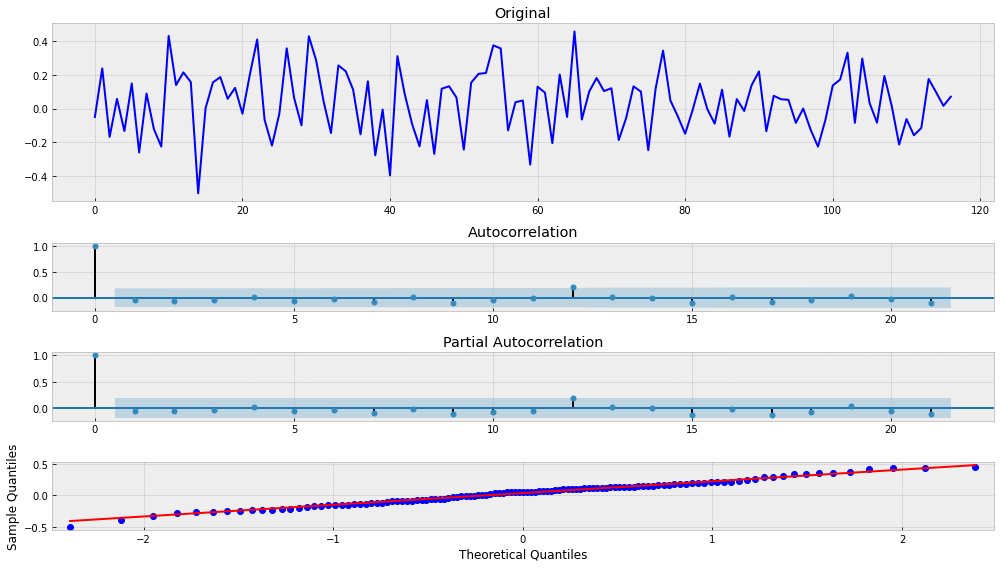

In [12]:
# посмотрим на остатки модели, качественно ли она сработала

tsplot(best_mdl.resid)

In [13]:
! pip install arch

You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


In [14]:
pip install arch --no-binary arch

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [15]:
pip install git+ssh://git@github.com/bashtage/arch.git@4.8.1

  Cloning ssh://****@github.com/bashtage/arch.git (to revision 4.8.1) to c:\users\urmas\appdata\local\temp\pip-req-build-0uzn6n1r
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q 'ssh://****@github.com/bashtage/arch.git' 'C:\Users\Urmas\AppData\Local\Temp\pip-req-build-0uzn6n1r'
  Host key verification failed.
  fatal: Could not read from remote repository.

  Please make sure you have the correct access rights
  and the repository exists.
ERROR: Command errored out with exit status 128: git clone -q 'ssh://****@github.com/bashtage/arch.git' 'C:\Users\Urmas\AppData\Local\Temp\pip-req-build-0uzn6n1r' Check the logs for full command output.
You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [16]:
pip install "arch==4.13"

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: arch==4.13 in c:\programdata\anaconda3\lib\site-packages (4.13)



You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [17]:
from arch import arch_model

In [18]:
test_size=0.15

# считаем индекс в датафрейме, после которого начинается тестовый отрезок
test_index = int(len(series)*(1-test_size))

# разбиваем весь датасет на тренировочную и тестовую выборку
train = series[:test_index]
test = series[test_index:]

In [19]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(train, p=p_, o=o_, q=q_, mean='Zero', vol='GARCH', dist='StudentsT')     # mean='Zero', vol='ARCH'   dist='StudentsT'
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     49,   Neg. LLF: -12.917993770785975
Iteration:     10,   Func. Count:     95,   Neg. LLF: -13.38422053594704
Iteration:     15,   Func. Count:    141,   Neg. LLF: 12209.565320001178
Iteration:     20,   Func. Count:    191,   Neg. LLF: -13.711196953404219
Iteration:     25,   Func. Count:    241,   Neg. LLF: -13.730284891652932
Iteration:     30,   Func. Count:    286,   Neg. LLF: -13.770234541571341
Iteration:     35,   Func. Count:    331,   Neg. LLF: -13.801597439872939
Optimization terminated successfully    (Exit mode 0)
            Current function value: -13.802905661442578
            Iterations: 39
            Function evaluations: 362
            Gradient evaluations: 37
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.010
Vol Model:       

Results of Dickey-Fuller Test:
Test Statistic                -9.744233e+00
p-value                        8.338232e-17
#Lags Used                     1.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (1%)           -3.499637e+00
Critical Value (5%)           -2.891831e+00
Critical Value (10%)          -2.582928e+00
dtype: float64


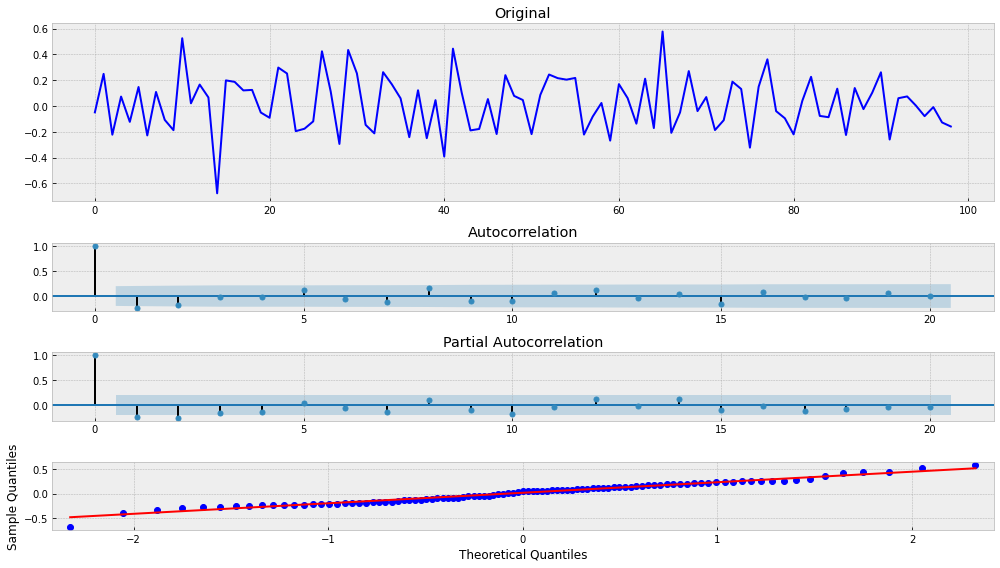

In [20]:
# посмотрим на остатки res

tsplot(res.resid)

Прогноз дисперсии через forecast

In [21]:
forecast = res.forecast(horizon=int(len(series)-test_index))

In [22]:
forecast

In [23]:
forecast.residual_variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,h.11,h.12,h.13,h.14,h.15,h.16,h.17,h.18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
var = [i * 0.01 for i in range(0,117)]

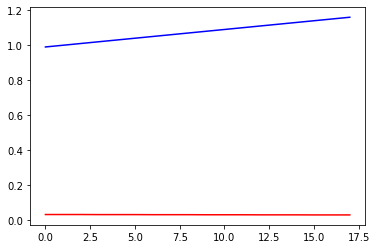

In [44]:
# график ожидаемой и прогнозируемой дисперсии

plt.plot(var[test_index:], color='blue')
#plt.plot(test, color='green')
plt.plot(forecast.variance.values[-1, :], color='red')
plt.show()

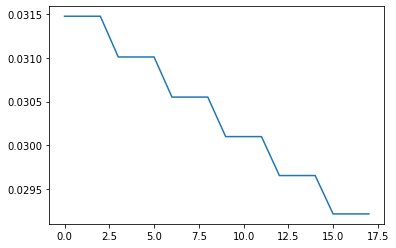

In [39]:
plt.plot(forecast.variance.values[-1, :])
plt.show()

In [28]:
forecast.variance.values[-1:]

array([[0.03147457, 0.03147457, 0.03147457, 0.03100958, 0.03100958,
        0.03100958, 0.03055146, 0.03055146, 0.03055146, 0.03010011,
        0.03010011, 0.03010011, 0.02965543, 0.02965543, 0.02965543,
        0.02921731, 0.02921731, 0.02921731]])

In [51]:
predicted_mu = best_mdl.predict(1, len(series) + 20)   # прогноз по ARIMA

In [64]:
forecast.mean

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,h.11,h.12,h.13,h.14,h.15,h.16,h.17,h.18
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
predicted_et = forecast.mean['h.01'].iloc[-1]

In [70]:
prediction = predicted_mu + predicted_et

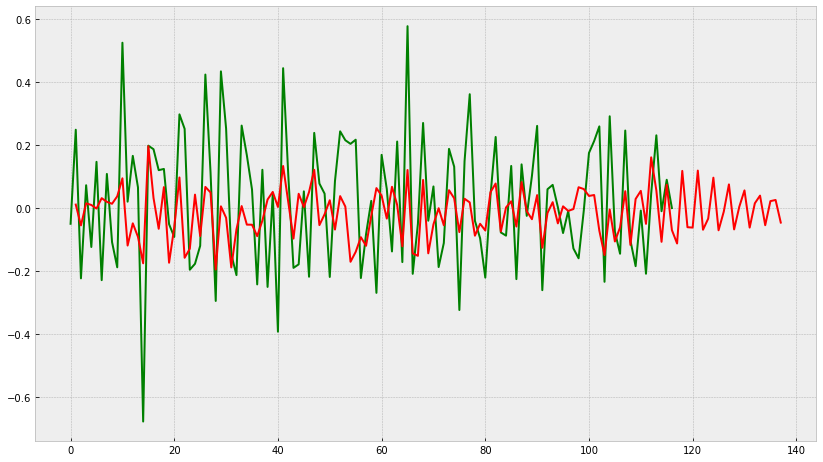

In [74]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(series, color='green')
    plt.plot(prediction, color='red')
    plt.show()

### Модели ARCH полезны только тогда, когда вы хотите спрогнозировать волатильность (дисперсию, которую могут иметь будущие данные), а не значение.  

Предскажем модель по линейной регрессии

In [29]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    #data = data.drop(["Month"], axis=1)   # в нашем ВР нет 'Month'
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [30]:
series = pd.DataFrame(series)
series.columns=['Count']
series.head()

,Count
0,-0.050010
1,0.248461
2,-0.223144
3,0.072321
4,-0.123614


In [31]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=35, test_size=0.3)

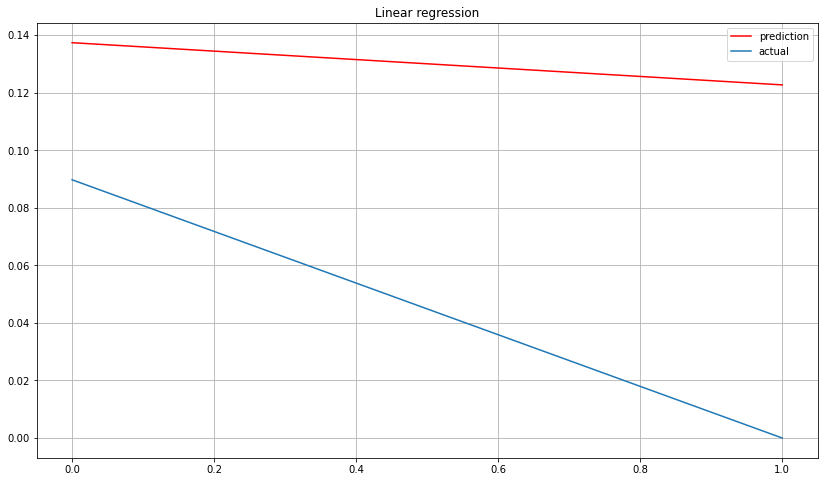

In [32]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);